# Реализация алгоритма Шора

In [2]:
from qiskit.circuit.library import QFT
from qiskit import QuantumCircuit
from qiskit import Aer, execute
from PIL import Image
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import gcd

# 1. Инициализация кубитов

In [3]:
def initialize_qubits(circuit, n, m):
    # Apply Hadamard gates to first n qubits
    circuit.h(range(n))
    
    # Apply X gate to last qubit
    circuit.x(n+m-1)

# 2. Модульное возведение в степень

In [4]:
def c_amod15(a, power):
    # Create quantum circuit for controlled U gate
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [5]:
def modular_exponentiation(circuit, n, m, a):
    # Apply controlled-U gates to implement modular exponentiation
    for x in range(n):
        exponent = 2**x
        circuit.append(c_amod15(a, exponent), [x] + list(range(n, n+m)))

# 3. Применение обратного квантового преобразования Фурье

In [6]:
def apply_iqft(given_circuit, measurement_qubits):
    # Apply inverse QFT to measurement qubits
    given_circuit.append(QFT(n , approximation_degree = n,inverse=True), range(n))

# 4. Реализация схемы

In [7]:
def shor_program(n, m, a):
    # Create quantum circuit with n+m qubits and n classical bits
    shor = QuantumCircuit(n+m, n)
    
    # Initialize qubits
    initialize_qubits(shor, n, m)
    shor.barrier()
    
    # Apply modular exponentiation function
    modular_exponentiation(shor, n, m, a)
    shor.barrier()
    
    # Apply inverse QFT
    apply_iqft(shor, range(n))
    
    # Measure qubits
    shor.measure(range(n), range(n))
    
    # Return circuit
    return shor    

In [8]:
n = 4; m = 4; a = 7
circuit = shor_program(n, m, a)
circuit.draw(fold=-1)

┌───┐ ░                                                              ░ ┌───────┐┌─┐         
q_0: ┤ H ├─░────────■─────────────────────────────────────────────────────░─┤0      ├┤M├─────────
     ├───┤ ░        │                                                     ░ │       │└╥┘┌─┐      
q_1: ┤ H ├─░────────┼──────────────■──────────────────────────────────────░─┤1      ├─╫─┤M├──────
     ├───┤ ░        │              │                                      ░ │  IQFT │ ║ └╥┘┌─┐   
q_2: ┤ H ├─░────────┼──────────────┼──────────────■───────────────────────░─┤2      ├─╫──╫─┤M├───
     ├───┤ ░        │              │              │                       ░ │       │ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────■────────░─┤3      ├─╫──╫──╫─┤M├
     └───┘ ░ ┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐ ░ └───────┘ ║  ║  ║ └╥┘
q_4: ──────░─┤0            ├┤0            ├┤0            ├┤0            ├─░───────────╫──╫──╫──╫─
           ░ │             ││             ││             ││             │ ░           ║  ║  ║  ║ 
q_5: ──────░─┤1            ├┤1            ├┤1            ├┤1            ├─░───────────╫──╫──╫──╫─
           ░ │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 │ ░           ║  ║  ║  ║ 
q_6: ──────░─┤2            ├┤2            ├┤2            ├┤2            ├─░───────────╫──╫──╫──╫─
     ┌───┐ ░ │             ││             ││             ││             │ ░           ║  ║  ║  ║ 
q_7: ┤ X ├─░─┤3            ├┤3            ├┤3            ├┤3            ├─░───────────╫──╫──╫──╫─
     └───┘ ░ └─────────────┘└─────────────┘└─────────────┘└─────────────┘ ░           ║  ║  ║  ║ 
c: 4/═════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                      0  1  2  3

# 5. Запуск программы на квантовом симуляторе

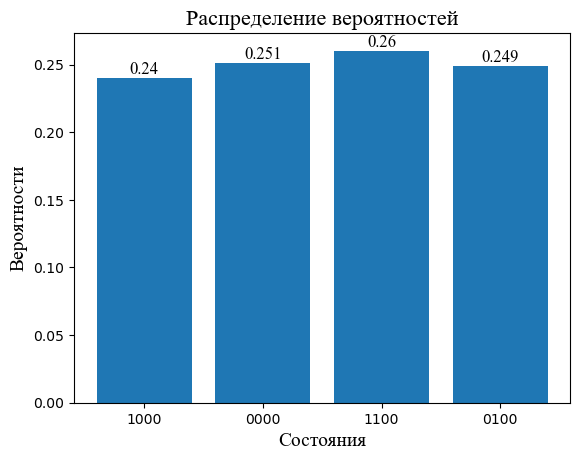

In [9]:
# Run circuit on simulator
simulator = Aer.get_backend('qasm_simulator')
counts = execute(circuit, backend=simulator, shots=4096).result().get_counts(circuit)
total_counts = sum(counts.values())
probabilities = [value / total_counts for value in counts.values()]
states = list(counts.keys())

# Plot results
plt.bar(states, probabilities)
plt.xlabel('Состояния', fontname='Times New Roman', fontsize=14)
plt.ylabel('Вероятности', fontname='Times New Roman', fontsize=14)
plt.title('Распределение вероятностей', fontname='Times New Roman', fontsize=16)
for i, v in enumerate(probabilities):
    plt.text(i, v, str(round(v, 3)), ha='center', va='bottom', fontname='Times New Roman', fontsize=12)
plt.savefig('my_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Классическая обработка для получения множителей числа 15

In [10]:
# Find most common measurement
measured_value = max(counts, key=counts.get)

In [11]:
# Convert measured value to decimal
measured_value_decimal = int(measured_value, 2)

# Find factors of 15 using measured value
if measured_value_decimal % 2 != 0:
    print("Failed. Measured value is not an even number")
else:
    x = int((a ** (measured_value_decimal // 2)) % 15)
    if (x + 1) % 15 == 0:
        print("Failed. x + 1 = 0 (mod N) where x = a^(r/2) (mod N)")
    else:
        guesses = gcd(x + 1, 15), gcd(x - 1, 15)
        print("Factors of 15 are", guesses)    

Factors of 15 are (5, 3)
